In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
base_dirs = {
    "Without": Path("data/Without EDM"),
    "With": Path("data/With EDM")
}

dfs = []

for edm_state, dir_path in base_dirs.items():
    for file in sorted(dir_path.glob("G2_*.pkl")):
        run_id = int(file.stem.split("_")[1])
        with open(file, "rb") as f:
            X, Y, Z = pickle.load(f)
        
        df = pd.DataFrame({
            "lambda_frac": X.ravel(),
            "theta_mrad": (Y * 1000).ravel(),
            "prob_density": Z.ravel(),
            "run_id": run_id,
            "edm_state": edm_state
        })
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [ ]:
output_base = Path("outputs")

for edm_state in tqdm(["With", "Without"], desc="EDM States"):
    # Match the folder names on disk
    folder_name = "With EDM" if edm_state == "With" else "Without EDM"
    output_dir = output_base / folder_name
    output_dir.mkdir(parents=True, exist_ok=True)

    for run_id in range(29):
        subset = df_all.query("edm_state == @edm_state and run_id == @run_id")
        if subset.empty:
            print(f"Skipping {edm_state} run {run_id:02} — no data found.")
            continue

        # Get unique sorted axes
        lambdas = np.sort(subset["lambda_frac"].unique())
        thetas = np.sort(subset["theta_mrad"].unique())

        # Reshape back into 2D grid
        Z_grid = subset.pivot_table(
            index="theta_mrad",
            columns="lambda_frac",
            values="prob_density"
        ).values

        # File name format
        if edm_state == "With":
            fname = f"G2_{run_id:02}_withEDM_heatmap.png"
        else:
            fname = f"G2_{run_id:02}_heatmap.png"

        save_path = output_dir / fname

        # Plot and save with no inline output
        plt.figure(figsize=(6,6))
        plt.imshow(
            Z_grid,
            extent=[lambdas.min(), lambdas.max(), thetas.min(), thetas.max()],
            aspect='auto',
            origin='lower',
            cmap='viridis'
        )
        plt.xlabel(r"Fractional energy ($\lambda$)")
        plt.ylabel(r"Longitudinal angle ($\theta_L$) [mrad]")
        plt.title(f"{folder_name} — Run {run_id:02}")
        plt.colorbar(label="Probability density")
        plt.tight_layout()
        plt.savefig(save_path, dpi=200)
        plt.close()

        print(f"Saved: {save_path.resolve()}")


EDM States:   0%|          | 0/2 [00:00<?, ?it/s]

Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_00_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_01_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_02_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_03_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_04_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_05_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_06_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Wit

EDM States:  50%|█████     | 1/2 [00:42<00:42, 42.80s/it]

Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\With EDM\G2_28_withEDM_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_00_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_01_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_02_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_03_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_04_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_05_heatmap.png
Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_06_heatmap.png
Sav

EDM States: 100%|██████████| 2/2 [01:29<00:00, 44.71s/it]

Saved: C:\Users\JakeS\OneDrive\Documents\University Work\Year 4\mphys-masters-project\outputs\Without EDM\G2_28_heatmap.png


C:\Users\JakeS\AppData\Local\Temp\ipykernel_4032\203099736.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_mean_error)


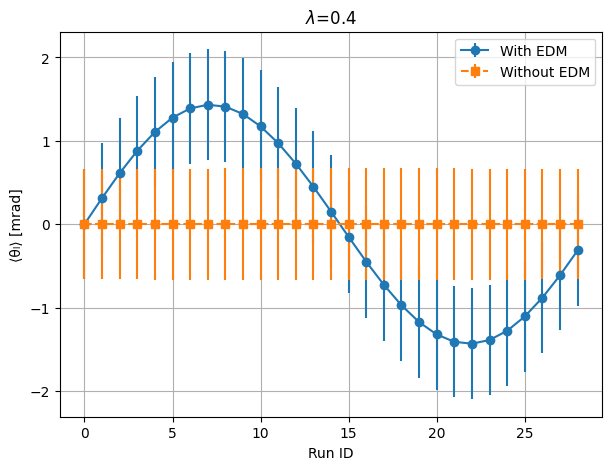

In [12]:
lambda_values = [0.4]
tol = 0.002

def weighted_mean_error(g):
    weights = g["prob_density"]
    theta = g["theta_mrad"]
    w_mean = np.sum(theta * weights) / np.sum(weights)
    w_var = np.sum(weights * (theta - w_mean)**2) / np.sum(weights)
    n = len(g)
    w_sem = np.sqrt(w_var) / np.sqrt(n)
    return pd.Series({"mean": w_mean, "sem": w_sem})

for lambda_curr in lambda_values:
    subset = df_all[(df_all["lambda_frac"] - lambda_curr).abs() < tol]

    results = (
    subset
    .groupby(["edm_state", "run_id"])
    .apply(weighted_mean_error)
    )

    angles = results.unstack("edm_state")

    means = results["mean"].unstack("edm_state")
    errors = results["sem"].unstack("edm_state")

    plt.figure(figsize=(7,5))
    plt.title(fr"$\lambda$={lambda_curr}")
    plt.errorbar(means.index, means["With"], yerr=errors["With"], fmt="o-", label="With EDM")
    plt.errorbar(means.index, means["Without"], yerr=errors["Without"], fmt="s--", label="Without EDM")
    plt.xlabel("Run ID")
    plt.ylabel("⟨θₗ⟩ [mrad]")
    plt.legend()
    plt.grid(True)
    plt.show()
